<a href="https://colab.research.google.com/github/AnIsAsPe/LogisticRegression_SpamOpinion/blob/master/Notebooks/Clasificador_rese%C3%B1as_Regresi%C3%B3n_log%C3%ADstica_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Bibliotecas

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\conte\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\conte\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\conte\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Funciones

In [3]:
def elimina_stopwords(texto):
  '''La función usa expresiones regulares (re) para quitar todas las palabras 
  que sean una palabra vacia:'''
  stop = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  nuevo_texto = stop.sub('', texto)
  return nuevo_texto

In [4]:
def elimina_puntuacion_y_numeros(texto):
  nuevo_texto = re.sub('[^a-z]+', ' ', texto)
  return nuevo_texto

In [5]:
def lematizar(texto):
  lemma = WordNetLemmatizer()
  texto = texto.split()
  texto2 = " ".join([lemma.lemmatize(i, 'v') for i in texto])
  nuevo_texto = " ".join([lemma.lemmatize(i, 'v') for i in texto])
  return nuevo_texto

In [6]:
def stemmer(texto):
  st = PorterStemmer()
  texto = texto.split()
  nuevo_texto = ' '.join([st.stem(i) for i in texto])
  return nuevo_texto

In [7]:
def preprocesar(texto):
  texto = texto.lower()
  texto = elimina_stopwords(texto)
  texto = elimina_puntuacion_y_numeros(texto)
  texto = stemmer(texto)
  return(texto)


# Lectura de datos y breve exploración

In [8]:
datos = pd.read_csv('C:\\Users\\conte\\OneDrive\\Escritorio\\Colegio Bourbaki\\RegresionLogisitica\\LogisticRegression_SpamOpinion-master\\Datos\\spam_enron1.csv',
                    usecols=['label', 'text', 'label_num']

                    )
print(datos.shape)
datos.head()

(5171, 3)


,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [9]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [10]:
datos.label.value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

In [11]:
y = datos['label_num']

# Preprocesamiento de texto

In [12]:
datos['text']

0       Subject: enron methanol ; meter # : 988291\r\n...
1       Subject: hpl nom for january 9 , 2001\r\n( see...
2       Subject: neon retreat\r\nho ho ho , we ' re ar...
3       Subject: photoshop , windows , office . cheap ...
4       Subject: re : indian springs\r\nthis deal is t...
                              ...                        
5166    Subject: put the 10 on the ft\r\nthe transport...
5167    Subject: 3 / 4 / 2000 and following noms\r\nhp...
5168    Subject: calpine daily gas nomination\r\n>\r\n...
5169    Subject: industrial worksheets for august 2000...
5170    Subject: important online banking alert\r\ndea...
Name: text, Length: 5171, dtype: object

In [13]:
datos['long_text'] = datos['text'].str.len()

In [14]:
datos 

,label,text,label_num,long_text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,327
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,97
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524
3,spam,"Subject: photoshop , windows , office . cheap ...",1,414
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,336
...,...,...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,0,534
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0,1114
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0,402
5169,ham,Subject: industrial worksheets for august 2000...,0,573


In [15]:
datos[datos['long_text']==datos['long_text'].max()]

,label,text,label_num,long_text
949,ham,"Subject: fw : "" red , white and blue out ""\r\n...",0,32258


#### Transformar texto a minúsculas

## Normalización
Existen dos principales técnicas para normalizar el texto, la lematización y "radicalización" o stemming, que consiste en la  conversión de palabras en las raices

## Todo junto

In [16]:
datos['text_pp'] = datos['text'].apply(preprocesar)
datos['long_text_pp'] = datos['text_pp'].str.len()
datos['text_pp'] = datos['text_pp'].str.slice(start=8) # remueve la palabra subject
datos.head()

,label,text,label_num,long_text,text_pp,long_text_pp
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,327,enron methanol meter follow note gave monday p...,198
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,97,hpl nom januari see attach file hplnol xl hpln...,59
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524,neon retreat ho ho ho around wonder time year ...,1263
3,spam,"Subject: photoshop , windows , office . cheap ...",1,414,photoshop window offic cheap main trend abas d...,342
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,336,indian spring deal book teco pvr revenu unders...,173


# Visualización de nubes de palabras

In [17]:
def nube_palabras(sec_textos):
    # Crear la cadena con la que haremos la nube de palabras
    text= " ".join(review for review in sec_textos)
    
    # Crear la nube de palabras
    wordcloud = WordCloud(max_font_size=50, 
                          max_words=100, 
                          background_color="white").generate(text)

    # Desplegar la imagen generada
    plt.figure(figsize=[10,12])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

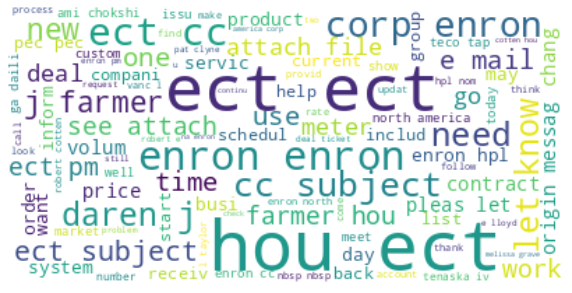

In [18]:
nube_palabras(datos['text_pp'])

In [19]:
porClase = datos.groupby('label_num')
ham = porClase.get_group(0).text_pp
spam = porClase.get_group(1).text_pp

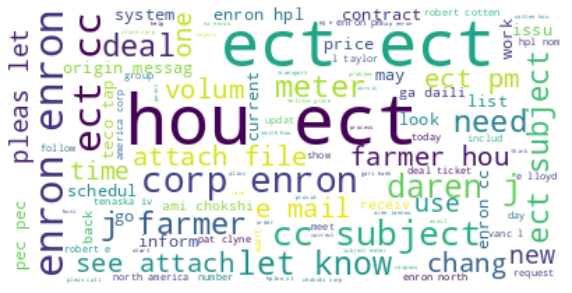

In [20]:
nube_palabras(ham)

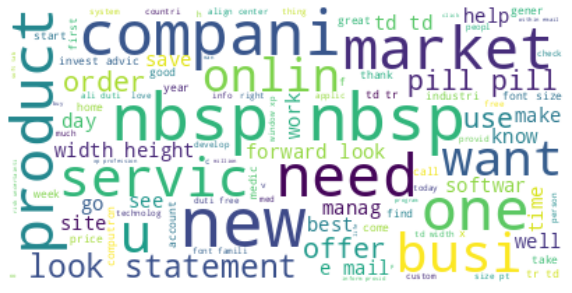

In [21]:
nube_palabras(spam)

# Vectorización de Texto mediante BOW

In [22]:
vectorizer = TfidfVectorizer(min_df=2)
BOW = vectorizer.fit_transform(datos['text_pp'])
BOW.shape

(5171, 16048)

In [23]:
BOW.todense()[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [24]:
palabras = vectorizer.get_feature_names_out()
X = pd.DataFrame(BOW.todense(), index=datos.index, columns=palabras)
X

,aa,aaa,aac,aalland,aarhu,aaron,aavil,ab,aba,ababa,...,zs,ztop,zu,zur,zurich,zv,zw,zwallet,zwier,zyban
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Regresión Logística sin penalización

In [25]:
# Dividir datos en entrenamiento y prueba
X_train, X_test , y_train, y_test = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True,   
                                                     random_state=9
                                                     )

clasificador_rl = LogisticRegression(penalty= 'none',
                                     random_state=4, 
                                     solver="newton-cg").fit(X_train, y_train)
clasificador_rl.score(X_test, y_test)

0.9903381642512077

In [26]:
def evaluación(modelo, conjunto):
    mensaje_error = 'conjunto solo puede ser "entrenamiento" o "prueba"'
    assert conjunto in ['entrenamiento', 'prueba'], mensaje_error


    if conjunto == 'entrenamiento':
      X = X_train
      y = y_train
    else:
      X = X_test
      y = y_test    
   

    y_pred = modelo.predict(X)
    precision = accuracy_score(y, y_pred)*100

    # creamos un diccionario con las etiquetas
    data = {'y_Real':  y,
            'y_Prediccion': y_pred
            }
    # lo convertimos en un DataFrame de pandas
    df = pd.DataFrame(data, columns=['y_Real','y_Prediccion'])

    # hacemos una tabla crusada para obtener la matriz de confusión
    confusion_matrix = pd.crosstab(df['y_Real'], df['y_Prediccion'], 
                                   rownames=['Real'], colnames=['Predicción'])

    # realizamos un mapa de calor
    titulo = 'Datos:{}, precisión = {:4.2f}'.format(conjunto, precision)
    sns.heatmap(confusion_matrix, annot=True, fmt='g').set(title = titulo)
    plt.show()


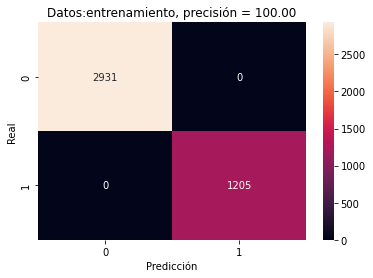

In [27]:
evaluación(clasificador_rl, 'entrenamiento')

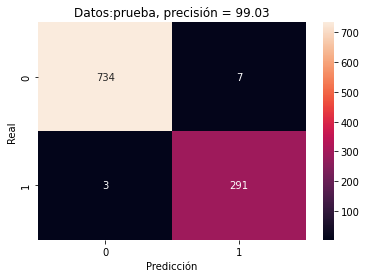

In [28]:
evaluación(clasificador_rl, 'prueba')

# Regresión Logística con penalización Ridge

## ¿De qué magnitud debe ser la fueza de la regularización (parámetro  λ)?

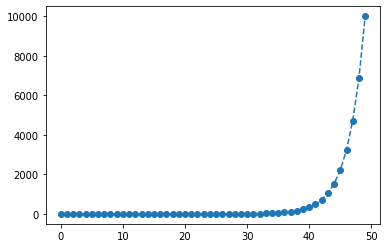

In [29]:
lambdas = np.logspace( -4, 4, 50)
plt.plot(lambdas, linestyle='--', marker='o')
plt.show()

In [30]:
lambdas

array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.68511374e-02, 1.26485522e-01,
       1.84206997e-01, 2.68269580e-01, 3.90693994e-01, 5.68986603e-01,
       8.28642773e-01, 1.20679264e+00, 1.75751062e+00, 2.55954792e+00,
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04])

In [31]:
%%time
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(LogisticRegression(penalty='l2',max_iter=500), 
                           { 'C': 1/lambdas}, cv=5, return_train_score=False) #Parametro cv divide la base de datos en 5 partes
grid_search.fit(X, y)

CPU times: total: 1h 28min 48s
Wall time: 11min 14s


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': array([1.00000000e+04, 6.86648845e+03, 4.71486636e+03, 3.23745754e+03,
       2.22299648e+03, 1.52641797e+03, 1.04811313e+03, 7.19685673e+02,
       4.94171336e+02, 3.39322177e+02, 2.32995181e+02, 1.59985872e+02,
       1.09854114e+02, 7.54312006e+01, 5.17947468e+01, 3.55648031e+01,
       2.44205309e+01, 1.67683294e...
       1.20679264e+00, 8.28642773e-01, 5.68986603e-01, 3.90693994e-01,
       2.68269580e-01, 1.84206997e-01, 1.26485522e-01, 8.68511374e-02,
       5.96362332e-02, 4.09491506e-02, 2.81176870e-02, 1.93069773e-02,
       1.32571137e-02, 9.10298178e-03, 6.25055193e-03, 4.29193426e-03,
       2.94705170e-03, 2.02358965e-03, 1.38949549e-03, 9.54095476e-04,
       6.55128557e-04, 4.49843267e-04, 3.08884360e-04, 2.12095089e-04,
       1.45634848e-04, 1.00000000e-04])})

In [32]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.390582,0.734481,0.100805,0.004351,10000.0,{'C': 10000.0},0.985507,0.984526,0.983559,0.982592,0.991296,0.985496,0.003058,23
1,4.739087,0.657730,0.099009,0.007123,6866.48845,{'C': 6866.488450042998},0.985507,0.984526,0.983559,0.982592,0.991296,0.985496,0.003058,23
2,5.158777,0.753908,0.097004,0.002829,4714.866363,{'C': 4714.866363457394},0.985507,0.984526,0.984526,0.982592,0.991296,0.985689,0.002959,21
3,5.589455,1.076345,0.100802,0.004118,3237.457543,{'C': 3237.4575428176436},0.984541,0.984526,0.984526,0.982592,0.991296,0.985496,0.002996,22
4,4.973988,0.669586,0.104802,0.004750,2222.996483,{'C': 2222.9964825261955},0.984541,0.984526,0.984526,0.984526,0.991296,0.985883,0.002706,19
5,4.941141,0.819056,0.096810,0.001467,1526.417967,{'C': 1526.4179671752333},0.984541,0.984526,0.985493,0.985493,0.991296,0.986270,0.002549,18
6,5.356576,0.862090,0.099002,0.004517,1048.113134,{'C': 1048.1131341546852},0.984541,0.985493,0.985493,0.984526,0.991296,0.986270,0.002549,14
7,5.804038,0.398707,0.098007,0.001260,719.685673,{'C': 719.6856730011522},0.984541,0.985493,0.985493,0.983559,0.990329,0.985883,0.002335,19
8,5.421789,1.057698,0.102002,0.004050,494.171336,{'C': 494.1713361323838},0.984541,0.985493,0.985493,0.984526,0.991296,0.986270,0.002549,14
9,5.372593,0.525334,0.103601,0.008936,339.322177,{'C': 339.32217718953297},0.984541,0.985493,0.985493,0.984526,0.991296,0.986270,0.002549,14


In [33]:
grid_search.best_params_

{'C': 35.56480306223132}

In [34]:
C = grid_search.best_params_['C']

# valor de lambda
1 / grid_search.best_params_['C']

0.02811768697974228

In [35]:
clasificador_ridge = LogisticRegression(penalty= 'l2',  
                                        C = C, 
                                        random_state=4, 
                                        solver="newton-cg").fit(X_train, y_train)

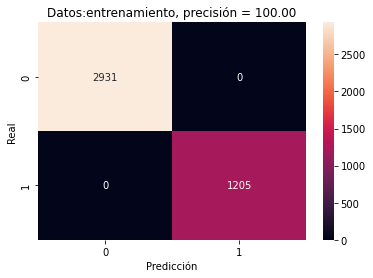

In [36]:
evaluación(clasificador_ridge, 'entrenamiento')

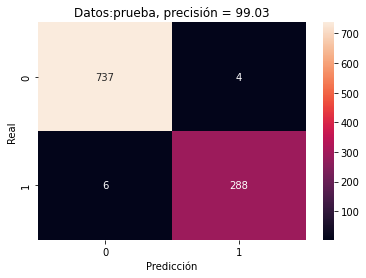

In [37]:
evaluación(clasificador_ridge, 'prueba')

# Predicciones y certeza de la predicción

In [38]:
resultados = {'P(0)' : clasificador_ridge.predict_proba(X_test)[:,0],
              'P(1)' : clasificador_ridge.predict_proba(X_test)[:,1], 
              'y_pred_50' : clasificador_ridge.predict(X_test),          
              }

predicciones = pd.DataFrame(resultados)
predicciones.sort_values('P(0)',
                         ascending=False).iloc[125:165]

,P(0),P(1),y_pred_50
543,0.999923,0.000077,0
756,0.999923,0.000077,0
989,0.999920,0.000080,0
535,0.999920,0.000080,0
742,0.999919,0.000081,0
53,0.999918,0.000082,0
945,0.999918,0.000082,0
331,0.999917,0.000083,0
987,0.999915,0.000085,0
165,0.999915,0.000085,0


In [39]:
predicciones['y_pred_30'] = np.where( predicciones['P(0)'] > .3, '0', '1')
predicciones.sort_values('P(0)',
                         ascending=False).iloc[125:185]

,P(0),P(1),y_pred_50,y_pred_30
543,0.999923,0.000077,0,0
756,0.999923,0.000077,0,0
989,0.999920,0.000080,0,0
535,0.999920,0.000080,0,0
742,0.999919,0.000081,0,0
53,0.999918,0.000082,0,0
945,0.999918,0.000082,0,0
331,0.999917,0.000083,0,0
987,0.999915,0.000085,0,0
165,0.999915,0.000085,0,0


### grafica_roc

In [40]:
def grafica_roc(clf, y_test):
    '''Grafica la curva ROC para el conjunto de prueba'''
    y_test_score = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve( y_test, y_test_score)
    roc_auc = auc(fpr, tpr)  #Area bajo la curva (AUC, por sus siglas en inglés)
    plt.figure()
    plt.plot(fpr, tpr, label="Curva ROC (area = %0.2f)" % roc_auc)  
    plt.plot([0, 1], [0, 1], "--")
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()



In [41]:
ytest_bin = np.where(y_test==0, 0, 1)


In [42]:
clf = clasificador_ridge
y_test_score = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve( ytest_bin, y_test_score)

from sklearn.preprocessing import MinMaxScaler
umbral_decisión = (MinMaxScaler().fit_transform(thresholds.reshape(-1,1)))[:,0]


i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),
                    'tpr' : pd.Series(tpr, index = i), 
                    'd_optimo': pd.Series(np.sqrt((fpr)**2+(1-tpr)**2), index=i),
                    'thresholds' : pd.Series(thresholds, index = i),
                    'umbral_decisión': pd.Series(umbral_decisión, index=i)})
roc

,fpr,tpr,d_optimo,thresholds,umbral_decisión
0,0.000000,0.000000,1.000000,1.999863e+00,1.000000
1,0.000000,0.003401,0.996599,9.998628e-01,0.499966
2,0.000000,0.551020,0.448980,9.730510e-01,0.486559
3,0.001350,0.551020,0.448982,9.730236e-01,0.486545
4,0.001350,0.744898,0.255106,9.295420e-01,0.464803
...,...,...,...,...,...
71,0.869096,1.000000,0.869096,4.199430e-05,0.000021
72,0.871795,1.000000,0.871795,4.085308e-05,0.000020
73,0.882591,1.000000,0.882591,3.110106e-05,0.000015
74,0.885290,1.000000,0.885290,3.097296e-05,0.000015


In [43]:
roc_ = roc.loc[1:56,:] # quitamos el primer y último renglón.


In [44]:
roc_[roc_['d_optimo']==roc_['d_optimo'].min()]

,fpr,tpr,d_optimo,thresholds,umbral_decisión
16,0.010796,0.993197,0.012761,0.360689,0.180357


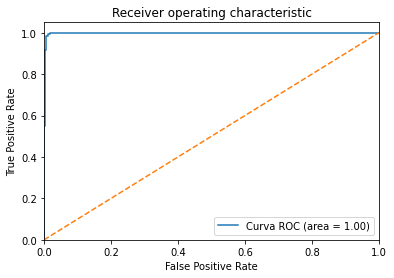

In [45]:
grafica_roc(clasificador_ridge, ytest_bin)

# Magnitud de los coeficientes para ambos modelos

In [46]:
clasificador_rl.coef_[0].shape

(16048,)

In [47]:
coeficientes_rl = pd.Series(clasificador_rl.coef_[0], 
                            index=palabras,
                            name='Sin regularización').sort_values(ascending=False)
coeficientes_rl

remov      30.332599
read       21.301117
money      20.619531
special    19.816166
http       18.032508
             ...    
know      -29.576484
meter     -30.484659
deal      -31.680887
daren     -33.010515
enron     -57.655325
Name: Sin regularización, Length: 16048, dtype: float64

In [48]:
coeficientes_rl.min(), coeficientes_rl.max()

(-57.655324859925614, 30.33259906200004)

In [49]:
coeficientes_ridge = pd.Series(clasificador_ridge.coef_[0],
                               index=palabras,
                               name='Ridge').sort_values(ascending=False)
coeficientes_ridge

remov        7.194389
http         5.827492
money        5.475563
read         4.633323
paliourg     4.235802
              ...    
know        -6.486362
meter       -7.308013
daren       -7.389466
deal        -7.466156
enron      -13.004411
Name: Ridge, Length: 16048, dtype: float64

In [50]:
                              
coeficientes_ridge.min(), coeficientes_ridge.max()

(-13.004411475858191, 7.1943888195393475)

In [51]:
# Observa las magnitudes de los coeficientes del modelo
#  sin y con regularización Ridge
coef = pd.concat([coeficientes_rl,coeficientes_ridge], axis=1)
coef

,Sin regularización,Ridge
remov,30.332599,7.194389
read,21.301117,4.633323
money,20.619531,5.475563
special,19.816166,3.658998
http,18.032508,5.827492
...,...,...
know,-29.576484,-6.486362
meter,-30.484659,-7.308013
deal,-31.680887,-7.466156
daren,-33.010515,-7.389466


In [52]:
# importancia de las palabras para predecir que es falsa la reseña
np.exp(coef).sort_values(by='Ridge')

,Sin regularización,Ridge
enron,9.132939e-26,0.000002
deal,1.742472e-14,0.000572
daren,4.610156e-15,0.000618
meter,5.763425e-14,0.000670
know,1.429211e-13,0.001524
...,...,...
paliourg,4.785344e+06,69.117106
read,1.782204e+09,102.855330
money,9.014643e+08,238.784923
http,6.782952e+07,339.506288


# Recursos

Para profundizar en grid_search_cv

https://github.com/codebasics/py/blob/master/ML/15_gridsearch/15_grid_search.ipynb